# Rudimentary use of gap_fit and quip to check for possible dissonances Hydrogen Tuple

In [1]:
# Import the data and leave out test data 
train_data = 'hydrogen_tuple_abs.xyz'

# File where Potential will be stored
potential = 'GAP_H2.xml'

##  Perform fit and write potential to out file --> .xml

In [2]:
! gap_fit energy_parameter_name=energy force_parameter_name=forces do_copy_at_file=F sparse_separate_file=T gp_file=GAP_H2.xml at_file=hydrogen_tuple_abs.xyz default_sigma={0.4 0.4 0 0} gap={distance_2b cutoff=3.0 covariance_type=ard_se delta=1 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10}


libAtoms::Hello World: 17/03/2021   14:25:34
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,357e28d15-dirty
libAtoms::Hello World: QUIP_ARCH    darwin_x86_64_gfortran
libAtoms::Hello World: compiled on  Jan 15 2021 at 14:52:24
libAtoms::Hello World: Random Seed = 51934824
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

atoms_filename = //MANDATORY//
at_file = hydrogen_tuple_abs.xyz
gap = "distance_2b cutoff=3.0 covariance_type=ard_se delta=1 theta_uniform=1.0 sparse_method=uniform add_species=T n_sparse=10"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = "0.4 0.4 0 0"
sparse_jitter = 1.0e-10
hessian_displacement = 1.0e-2
hessian_delta = 1.0e-2
baseline_param_filename = quip_params.xml
core_param_file = quip_params.xml
baseline_ip_args =
core_ip_args =


## Make predictions and write to out file --> .xyz

In [3]:
# File where predictions will be stored in
quip_train_H2 = 'quip_train_H2.xyz'

In [4]:
! quip E=T F=T atoms_filename=hydrogen_tuple_abs.xyz param_filename=GAP_H2.xml | grep AT | sed 's/AT//' > quip_train_H2.xyz


## Make helper functions for easier plotting

In [5]:
def energy_plot(in_file, out_file, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # read files
    in_atoms = ase.io.read(in_file, ':-1')
    out_atoms = ase.io.read(out_file, ':-1')
    # list energies
    ener_in = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in in_atoms]
    ener_out = [at.get_potential_energy() / len(at.get_chemical_symbols()) for at in out_atoms]
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP / eV')
    ax.set_xlabel('energy by EMT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

def force_plot(in_file, out_file, ax, symbol='H', title='Plot of force'):
    """ Plots the distribution of firce components per atom on the output vs the input
        only plots for the given atom type(s)"""

    in_atoms = ase.io.read(in_file, ':')
    out_atoms = ase.io.read(out_file, ':')

    # extract data for only one species
    in_force, out_force = [], []
    for at_in, at_out in zip(in_atoms, out_atoms):
        # get the symbols
        sym_all = at_in.get_chemical_symbols()
        # add force for each atom
        for j, sym in enumerate(sym_all):
            if sym in symbol:
                in_force.append(at_in.get_forces()[j])
                #out_force.append(at_out.get_forces()[j]) \
                out_force.append(at_out.arrays['force'][j]) # because QUIP and ASE use different names
    # convert to np arrays, much easier to work with
    #in_force = np.array(in_force)
    #out_force = np.array(out_force)
    # scatter plot of the data
    ax.scatter(in_force, out_force)
    # get the appropriate limits for the plot
    for_limits = np.array(in_force + out_force)
    flim = (for_limits.min() - 1, for_limits.max() + 1)
    ax.set_xlim(flim)
    ax.set_ylim(flim)
    # add line of
    ax.plot(flim, flim, c='k')
    # set labels
    ax.set_ylabel('force by GAP / (eV/Å)')
    ax.set_xlabel('force by EMT / (eV/Å)')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(in_force, out_force)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/Å'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

## Plot real values against predicted values to see quality of the fit

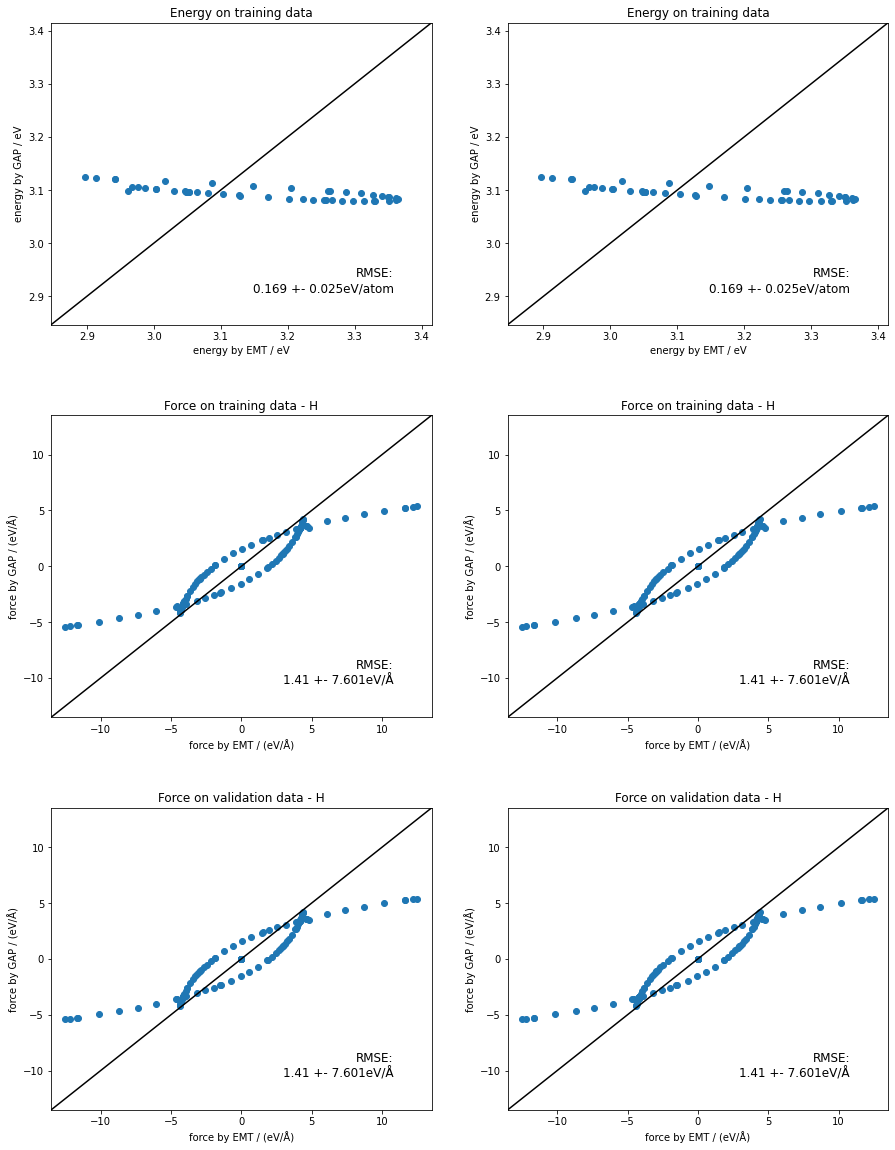

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ase.io
from ase import Atoms, Atom
from ase import units

fig, ax_list = plt.subplots(nrows=3, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

energy_plot('hydrogen_tuple_abs.xyz', 'quip_train_H2.xyz', ax_list[0], 'Energy on training data')
energy_plot('hydrogen_tuple_abs.xyz', 'quip_train_H2.xyz', ax_list[1], 'Energy on training data')
force_plot('hydrogen_tuple_abs.xyz', 'quip_train_H2.xyz', ax_list[2], 'H', 'Force on training data - H')
force_plot('hydrogen_tuple_abs.xyz', 'quip_train_H2.xyz', ax_list[3], 'H', 'Force on training data - H')
force_plot('hydrogen_tuple_abs.xyz', 'quip_train_H2.xyz', ax_list[4], 'H', 'Force on validation data - H')
force_plot('hydrogen_tuple_abs.xyz', 'quip_train_H2.xyz', ax_list[5], 'H',  'Force on validation data - H')

# if you wanted to have the same limits on the force plots
#for ax in ax_list[2:]:
#    flim = (-20, 20)
#    ax.set_xlim(flim)
#    ax.set_ylim(flim)